# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [ ]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score
!pip install -U -q chardet

In [ ]:
# Import essential libraries

import os
import pandas as pd
from tqdm import tqdm
import zipfile
import os
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import chardet
import os
import numpy as np

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

#### Uploading the dataset: The dataset is being uploaded manually for more control and transparency at this stage.

### Data Loading


In [ ]:
# Load the files as documents

# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Uploading the zip file
zip_path = '/content/drive/MyDrive/Colab Notebooks/rag_legal.zip'


In [ ]:
# Destination folder after extraction
extract_path = '/content/legal_docs_dataset'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed")

Extraction completed


In [ ]:
# List the contents of the extracted directory
for root, dirs, files in os.walk(extract_path):
    print(f"\n📁 Directory: {root}")
    for file in files:
        print(f"  └── 📄 {file}")



📁 Directory: /content/legal_docs_dataset

📁 Directory: /content/legal_docs_dataset/rag_legal

📁 Directory: /content/legal_docs_dataset/rag_legal/benchmarks
  └── 📄 cuad.json
  └── 📄 contractnli.json
  └── 📄 privacy_qa.json
  └── 📄 maud.json

📁 Directory: /content/legal_docs_dataset/rag_legal/corpus

📁 Directory: /content/legal_docs_dataset/rag_legal/corpus/contractnli
  └── 📄 stony_hill_buyer_nda.txt
  └── 📄 12032018_NDA_The_20Munt_EN.txt
  └── 📄 NDA-ONSemi_IndustryAnalystConf-2011.txt
  └── 📄 NDA-Dollar-General-Portfolio.txt
  └── 📄 ingram-non-disclosure.txt
  └── 📄 IGC-Non-Disclosure-Agreement-LSE-Sample.txt
  └── 📄 JB-Machine-LLC-NDA-1.txt
  └── 📄 DBT_20Mutual_20NDA.txt
  └── 📄 Petrolube_NDA.txt
  └── 📄 SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  └── 📄 BCG-Mutual-NDA.txt
  └── 📄 nda-employee-template.txt
  └── 📄 amc-general-mutual-non-disclosure-agreement-en-gb.txt
  └── 📄 Geheimhaltungsvereinbarung_Abschlussarbeiten_HFU_englisch.txt
  └── 📄 Inaturals_NDA.txt
  └── 📄 SupplementOn

In [ ]:
# Set the path

corpus_path = '/content/legal_docs_dataset/rag_legal/corpus'

In [ ]:
# Load the Text files

# Storage for all documents
documents = []

# Loop through each subfolder in the corpus
for folder_name in os.listdir(corpus_path):
    folder_path = os.path.join(corpus_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            if file_name.endswith('.txt'):
                try:
                    # Detect encoding
                    with open(file_path, 'rb') as raw_file:
                        encoding = chardet.detect(raw_file.read())['encoding'] or 'utf-8'

                    # Read file content
                    with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
                        content = f.read()

                    # Store with metadata
                    documents.append({
                        'file_name': file_name,
                        'folder': folder_name,
                        'file_path': file_path,
                        'content': content
                    })

                except Exception as e:
                    print(f"Error reading file: {file_path}\n{e}")

# Convert to DataFrame for further processing
df_docs = pd.DataFrame(documents)

# Show summary
print(f"Loaded {len(df_docs)} text files from corpus.")
df_docs.head()

Loaded 698 text files from corpus.


file_name       folder  \
0                 stony_hill_buyer_nda.txt  contractnli   
1           12032018_NDA_The_20Munt_EN.txt  contractnli   
2  NDA-ONSemi_IndustryAnalystConf-2011.txt  contractnli   
3         NDA-Dollar-General-Portfolio.txt  contractnli   
4                ingram-non-disclosure.txt  contractnli   

                                           file_path  \
0  /content/legal_docs_dataset/rag_legal/corpus/c...   
1  /content/legal_docs_dataset/rag_legal/corpus/c...   
2  /content/legal_docs_dataset/rag_legal/corpus/c...   
3  /content/legal_docs_dataset/rag_legal/corpus/c...   
4  /content/legal_docs_dataset/rag_legal/corpus/c...   

                                             content  
0  STANDARD BUYER'S NON-DISCLOSURE AND CONFIDENTI...  
1  Confidentiality Agreement\nThis Confidentialit...  
2   Confidentiality and Non-Disclosure Agreement\...  
3  Confidentiality Agreement – Non-Disclosure Agr...  
4  Non-Disclosure Agreement (APOD)\nThis Nondiscl...

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

### Preprocessing Steps:

 - Lowercasing: Convert all text to lowercase to ensure uniformity.

 - Remove Special Characters & Extra Whitespace: Eliminate non-alphanumeric characters (except periods, commas, etc.) and multiple spaces.

 - Remove Email, Phone Numbers, and URLs: Use regular expressions (regex) to filter out any email addresses, phone numbers, or URLs that may appear in the text.

 - Tokenization & Stopword Removal: Split the text into tokens (words) and remove common stopwords (e.g., "the", "is", "and").

 - Handle Missing or Corrupted Data: Skip files that are corrupted or have missing content, and log the errors.

In [ ]:
# Clean and preprocess the data

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers (pattern assumes standard format like (xxx) xxx-xxxx or xxx-xxx-xxxx)
    text = re.sub(r'\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}', '', text)

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove multiple spaces
    text = re.sub(r'\n{2,}', '\n', text)

    # Remove Page Numbers
    text = re.sub(r'Page\s+\d+', '', text)

    # Remove Headers/Footers
    text = re.sub(r'\s{2,}', ' ', text)

    return text

# Function to process and clean documents
def clean_documents(doc_df):
    # Remove rows with missing content
    doc_df = doc_df.dropna(subset=['content'])

    # Clean each document
    doc_df['cleaned_content'] = doc_df['content'].apply(preprocess_text)

    return doc_df

# Load dataset
corpus_path = '/content/legal_docs_dataset/rag_legal/corpus'

df_docs = clean_documents(df_docs)

# Example check
print(f"Cleaned {len(df_docs)} documents.")
print(df_docs[['file_name', 'cleaned_content']].head())

Cleaned 698 documents.
                                 file_name  \
0                 stony_hill_buyer_nda.txt   
1           12032018_NDA_The_20Munt_EN.txt   
2  NDA-ONSemi_IndustryAnalystConf-2011.txt   
3         NDA-Dollar-General-Portfolio.txt   
4                ingram-non-disclosure.txt   

                                     cleaned_content  
0  standard buyers nondisclosure and confidential...  
1  confidentiality agreement this confidentiality...  
2  confidentiality and nondisclosure agreement th...  
3  confidentiality agreement nondisclosure agreem...  
4  nondisclosure agreement apod this nondisclosur...  


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

### Exploring the data to understand the legal document dataset, its structure, content and pattenrs

In [ ]:
# Dataset Overview

df_docs.head()
df_docs.info()
df_docs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_name        698 non-null    object
 1   folder           698 non-null    object
 2   file_path        698 non-null    object
 3   content          698 non-null    object
 4   cleaned_content  698 non-null    object
dtypes: object(5)
memory usage: 27.4+ KB


file_name folder  \
count                                                 698    698   
unique                                                698      4   
top     PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-ST...   cuad   
freq                                                    1    462   

                                                file_path  \
count                                                 698   
unique                                                698   
top     /content/legal_docs_dataset/rag_legal/corpus/c...   
freq                                                    1   

                                                  content  \
count                                                 698   
unique                                                696   
top     Exhibit 10.7\n\nCONSULTING AGREEMENT\n\nAduro ...   
freq                                                    2   

                                          cleaned_content  
count                                                 698  
unique                                                696  
top     exhibit consulting agreement aduro biotech inc...  
freq                                                    2

In [ ]:
# Document counts per folder

df_docs['folder'].value_counts()

folder
cuad           462
maud           134
contractnli     95
privacy_qa       7
Name: count, dtype: int64

In [ ]:
# Number of Words per document

df_docs['num_words'] = df_docs['cleaned_content'].apply(lambda x: len(x.split()))
df_docs[['folder','num_words']].describe()


num_words
count     698.000000
mean    15683.120344
std     20406.696481
min       207.000000
25%      2356.250000
50%      5698.000000
75%     19310.750000
max    153799.000000

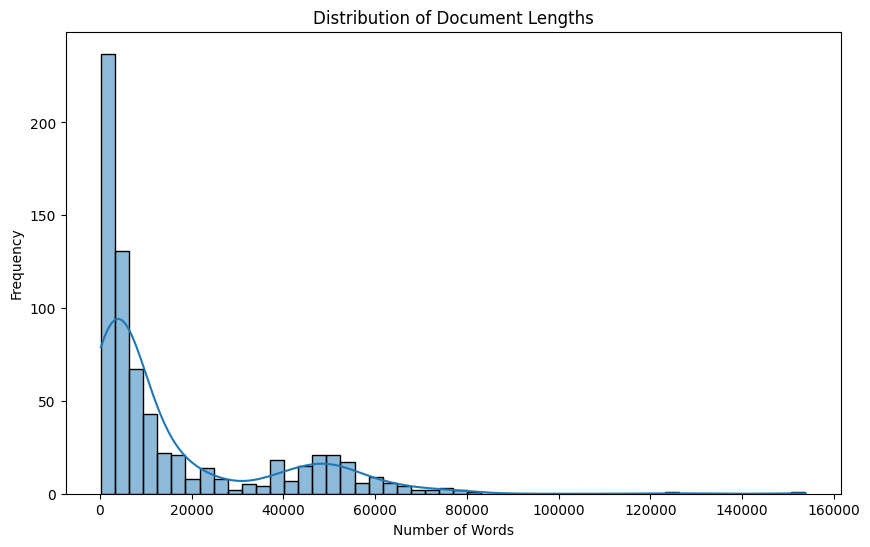

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_docs['num_words'], bins=50, kde=True)
plt.title('Distribution of Document Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Comparing the document lengths before and after tokenizing

# Define the statistics for before and after processing
before_stats = [avg_length_bef, max_length_bef, min_length_bef]
after_stats = [avg_length_after, max_length_after, min_length_after]

# Define labels
labels = ['Average Length', 'Max Length', 'Min Length']

# Set the x positions
x = range(len(labels))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, before_stats, width=0.4, label='Before Processing', align='center')
plt.bar(x, after_stats, width=0.4, label='After Processing', align='edge')

# Add titles and labels
plt.title('Document Length Statistics Before and After Processing')
plt.xlabel('Statistic')
plt.ylabel('Document Length (Tokens)')
plt.xticks(x, labels)
plt.legend(loc='upper left')

# Display the plot
plt.show()

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [ ]:
# Calculate the average, maximum and minimum document length.

# Calculate document length (in terms of word count)
df_docs['doc_length'] = df_docs['cleaned_content'].apply(lambda x: len(x.split()))

# Calculate average, max, and min document length
avg_length_bef = df_docs['doc_length'].mean()
max_length_bef = df_docs['doc_length'].max()
min_length_bef = df_docs['doc_length'].min()

print(f"Average Document Length: {avg_length_bef:.2f} words")
print(f"Maximum Document Length: {max_length_bef} words")
print(f"Minimum Document Length: {min_length_bef} words")



Average Document Length: 15683.12 words
Maximum Document Length: 153799 words
Minimum Document Length: 207 words


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [ ]:
import nltk
from nltk.data import find

# Clear NLTK cache
nltk.data.path = ['/root/nltk_data']  # Reset path if needed
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Find frequency of occurence of words

import re
from nltk.corpus import stopwords

# Loading stopwords
stop_words = set(stopwords.words('english'))

# Custom Tokenization function using regex
def clean_and_tokenize(text):
    try:
        # Tokenize using regex- split on non-alphabetic characters and lower case
        words = re.findall(r'\b\w+\b', text.lower())
        # Removed stopwords and non-alphabetic tokens
        return [word for word in words if word not in stop_words]
    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

# Apply the custom tokenizer to the cleaned content
df_docs['tokens'] = df_docs['cleaned_content'].apply(clean_and_tokenize)

# Check the first few tokenized documents
print(df_docs[['file_name', 'tokens']].head())


                                 file_name  \
0                 stony_hill_buyer_nda.txt   
1           12032018_NDA_The_20Munt_EN.txt   
2  NDA-ONSemi_IndustryAnalystConf-2011.txt   
3         NDA-Dollar-General-Portfolio.txt   
4                ingram-non-disclosure.txt   

                                              tokens  
0  [standard, buyers, nondisclosure, confidential...  
1  [confidentiality, agreement, confidentiality, ...  
2  [confidentiality, nondisclosure, agreement, co...  
3  [confidentiality, agreement, nondisclosure, ag...  
4  [nondisclosure, agreement, apod, nondisclosure...  


In [ ]:
# After tokenization

# Calculate the length of each document (number of tokens)
df_docs['doc_length'] = df_docs['tokens'].apply(len)

# Calculate average, maximum, and minimum document length
avg_length_after = df_docs['doc_length'].mean()
max_length_after = df_docs['doc_length'].max()
min_length_after = df_docs['doc_length'].min()

print(f"Average Document Length: {avg_length_after}")
print(f"Maximum Document Length: {max_length_after}")
print(f"Minimum Document Length: {min_length_after}")


Average Document Length: 8620.320916905444
Maximum Document Length: 82546
Minimum Document Length: 132


In [ ]:
# Get the most common and least common words

from collections import Counter

# Flatten the list of tokens
all_tokens = [token for tokens in df_docs['tokens'] for token in tokens]

# Get the frequency of each word
word_freq = Counter(all_tokens)

In [ ]:
# Get the 20 most common words
most_common_words = word_freq.most_common(20)

print("20 Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

20 Most Common Words:
company: 148175
shall: 107998
agreement: 104577
section: 75368
parent: 58010
party: 49664
date: 39300
time: 35256
material: 34211
merger: 33848
subsidiaries: 33318
b: 31719
applicable: 31370
including: 29399
respect: 28848
may: 28114
stock: 26654
information: 25687
parties: 24614
business: 23531


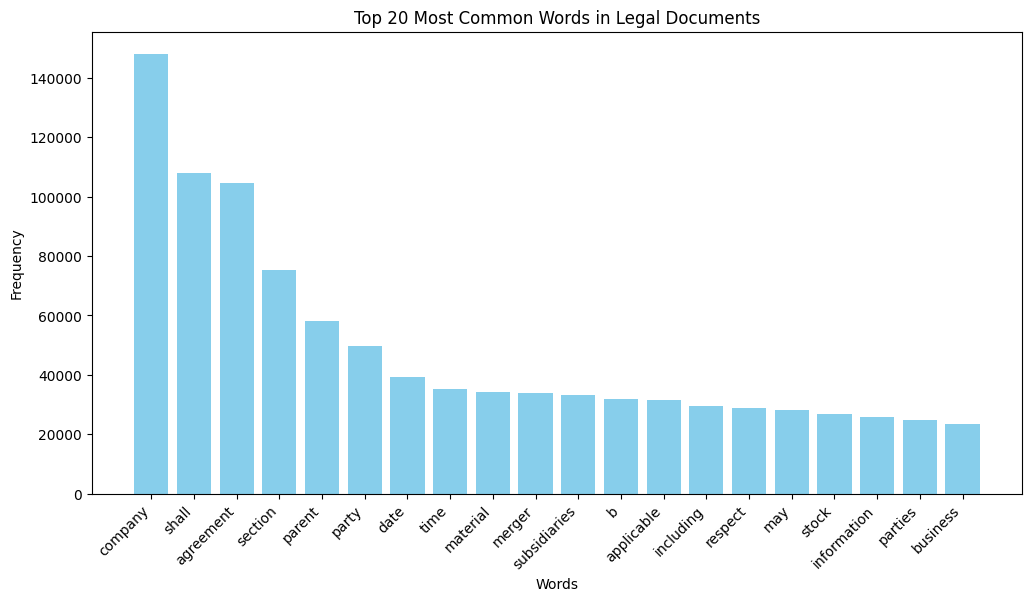

In [ ]:
# Bar plotof Most Common words

import matplotlib.pyplot as plt

# Separate words and counts
words, counts = zip(*most_common_words)

plt.figure(figsize=(12,6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Common Words in Legal Documents")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Get the 20 least common words
least_common_words = word_freq.most_common()[-20:]

print("20 Least Common Words:")
for word, freq in least_common_words:
    print(f"{word}: {freq}")

20 Least Common Words:
wwwcontinentalcom: 1
canons: 1
rickmansworth: 1
herts: 1
serono: 1
anvisa: 1
corroded: 1
notw: 1
tand: 1
ob: 1
iga: 1
mhra: 1
orchard: 1
px: 1
lunchtime: 1
betasp: 1
viewership: 1
distasteful: 1
cabledate: 1
mediadate: 1


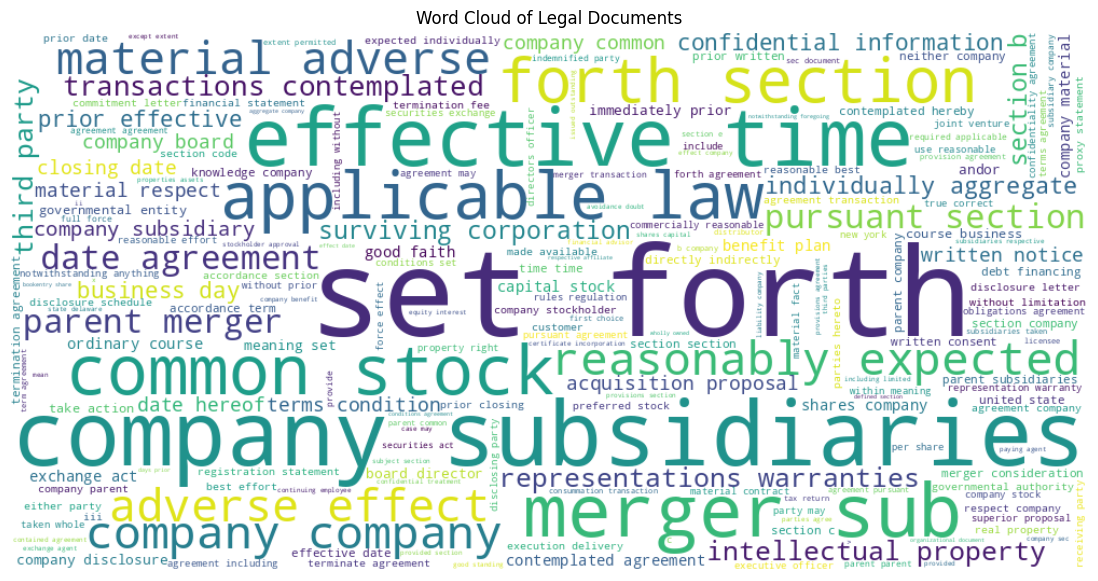

In [ ]:
# Word Cloud of Most Frequent words

from wordcloud import WordCloud

# Combine all words into a single string for the wordcloud
all_words_text = ' '.join([word for tokens in df_docs['tokens'] for word in tokens])

wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=200).generate(all_words_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Legal Documents")
plt.show()


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [ ]:
# Transform the page contents of documents

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert the tokens back to a string format for TF-IDF
df_docs['text'] = df_docs['tokens'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df_docs['text'])

# Check the shape of the resulting TF-IDF matrix (number of documents, number of unique terms)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute similarity scores
cosine_sim = cosine_similarity(tfidf_matrix)

TF-IDF Matrix Shape: (698, 35701)


In [ ]:
# Check the similarity for the first 10 documents

cosine_sim_10 = cosine_sim[:10, :10]
print("Similarity for the First 10 Documents:")
print(cosine_sim_10)

Similarity for the First 10 Documents:
[[1.         0.0844901  0.12469754 0.66393367 0.08108075 0.15217701
  0.12700098 0.14671143 0.08274122 0.16789921]
 [0.0844901  1.         0.12843972 0.06762101 0.06031988 0.15666507
  0.10376868 0.14085776 0.05933268 0.1559741 ]
 [0.12469754 0.12843972 1.         0.15829774 0.23204978 0.49216728
  0.4161107  0.4263177  0.17108539 0.4433436 ]
 [0.66393367 0.06762101 0.15829774 1.         0.07835513 0.20036114
  0.27390703 0.16378956 0.10270979 0.20162522]
 [0.08108075 0.06031988 0.23204978 0.07835513 1.         0.26345345
  0.26713228 0.18763426 0.07945175 0.19360031]
 [0.15217701 0.15666507 0.49216728 0.20036114 0.26345345 1.
  0.46235012 0.6981805  0.28412801 0.65446604]
 [0.12700098 0.10376868 0.4161107  0.27390703 0.26713228 0.46235012
  1.         0.31041442 0.13766314 0.32855829]
 [0.14671143 0.14085776 0.4263177  0.16378956 0.18763426 0.6981805
  0.31041442 1.         0.22955114 0.71943577]
 [0.08274122 0.05933268 0.17108539 0.10270979 0.07

In [ ]:
# create a list of 10 random integers

# Set the seed for reproducibility
np.random.seed(42)

# Generate 10 random indices from the range of document indices (0 to 697)
random_indices = np.random.choice(df_docs.index, size=10, replace=False)

# Print the random indices
print("10 Random Integers:", random_indices)

10 Random Integers: [158 499 396 155 321 212 234 289 300 356]


In [ ]:
# Compute similarity scores for 10 random documents

# Extract the cosine similarity matrix for these random documents
cosine_sim_random = cosine_sim[random_indices, :][:, random_indices]

print("Similarity score for 10 Random Documents:")
print(cosine_sim_random)

Similarity score for 10 Random Documents:
[[1.         0.10582552 0.06936389 0.81551753 0.31541497 0.85073475
  0.06412235 0.03356759 0.13864471 0.07012194]
 [0.10582552 1.         0.0708791  0.13810947 0.06588917 0.12392755
  0.03482742 0.02319045 0.07369104 0.058178  ]
 [0.06936389 0.0708791  1.         0.09425976 0.04562467 0.08762078
  0.03236677 0.01498526 0.05169643 0.0371955 ]
 [0.81551753 0.13810947 0.09425976 1.         0.42003814 0.86841577
  0.08028147 0.04724317 0.19054704 0.09518413]
 [0.31541497 0.06588917 0.04562467 0.42003814 1.         0.40658277
  0.08670209 0.03454412 0.1317934  0.04977667]
 [0.85073475 0.12392755 0.08762078 0.86841577 0.40658277 1.
  0.06861874 0.04452682 0.17567606 0.08401651]
 [0.06412235 0.03482742 0.03236677 0.08028147 0.08670209 0.06861874
  1.         0.03126798 0.02558065 0.05942858]
 [0.03356759 0.02319045 0.01498526 0.04724317 0.03454412 0.04452682
  0.03126798 1.         0.04411417 0.01990383]
 [0.13864471 0.07369104 0.05169643 0.19054704 

## Observations:

### First 10 Documents - High similarity
- The similarity score range is ~0.70 to ~0.94
- The first 10 documents are highly similar, likely belong to same category
- They may share duplicate clauses or there may be seeing versions same contract between different parties

## Random 10 Documents - Mixed and Lower similarity

- The similarity score range is ~0.02 to ~0.42, Lower overall similarity
- Some pairs are quite dissimilar
- Highest observed score is ~0.42 between two documents and Majority are under 0.20

## Bivariate Analysis

  - AS we have TF-IDF similarity scores, we can perform Bivariate and Multivariate analysis
  - Document Length vs. Avg TF-IDF similarity checks if longer documents are more similar or less similar to others
  - Word Count of specific terms vs Document type sees if certain legal documents are more common in specific types of contracts

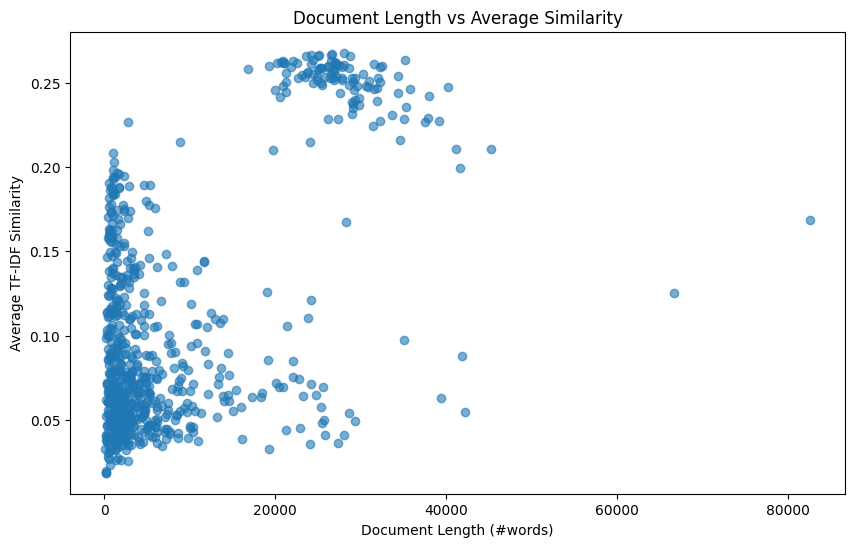

In [ ]:
# Document Length vs. Average TF-IDF Similarity

import numpy as np
import matplotlib.pyplot as plt

# Compute document length
df_docs['doc_length'] = df_docs['text'].apply(lambda x: len(x.split()))

# Average similarity for each document
df_docs['avg_similarity'] = cosine_sim.mean(axis=1)

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_docs['doc_length'], df_docs['avg_similarity'], alpha=0.6)
plt.xlabel("Document Length (#words)")
plt.ylabel("Average TF-IDF Similarity")
plt.title("Document Length vs Average Similarity")
plt.show()

Obervations:

  - There isn’t a strict linear relationship between document length and similarity.

  - Similarity depends not just on length, but on content overlap, which makes sense for legal documents: some long documents are very unique, and some moderate-length ones are repetitive.

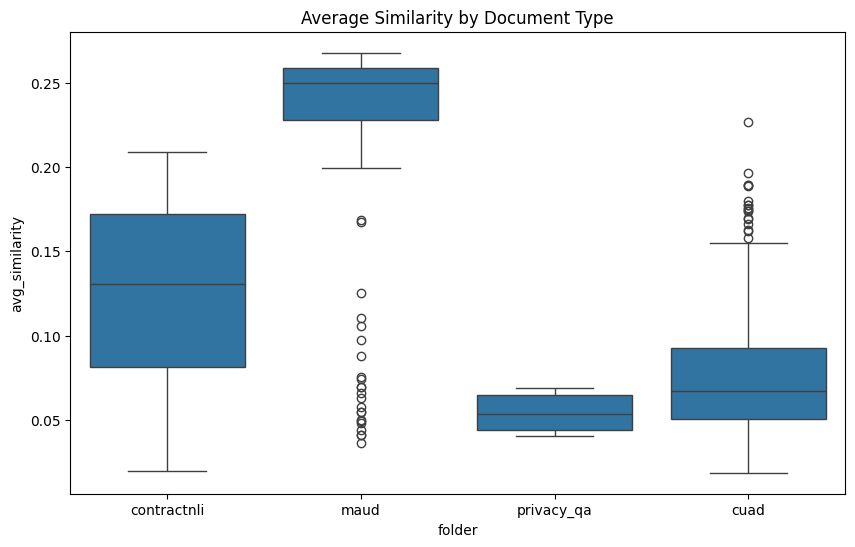

In [ ]:
# Document Type vs Average Similarity

import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='folder', y='avg_similarity', data=df_docs)
plt.title("Average Similarity by Document Type")
plt.show()


Obseravtions:

  - maud documents are the most similar on average, while privacy_qa documents show the least similarity.

  - The variability is highest in contractnli, suggesting diverse document types or content.

  - cuad shows a consistent low similarity with a long tail of outliers.

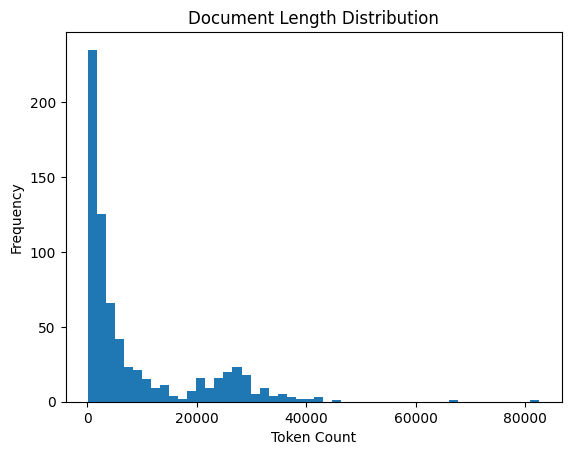

In [ ]:
# Plot document lengths (token count)

df_docs['token_count'] = df_docs['tokens'].apply(len)
plt.hist(df_docs['token_count'], bins=50)
plt.title('Document Length Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

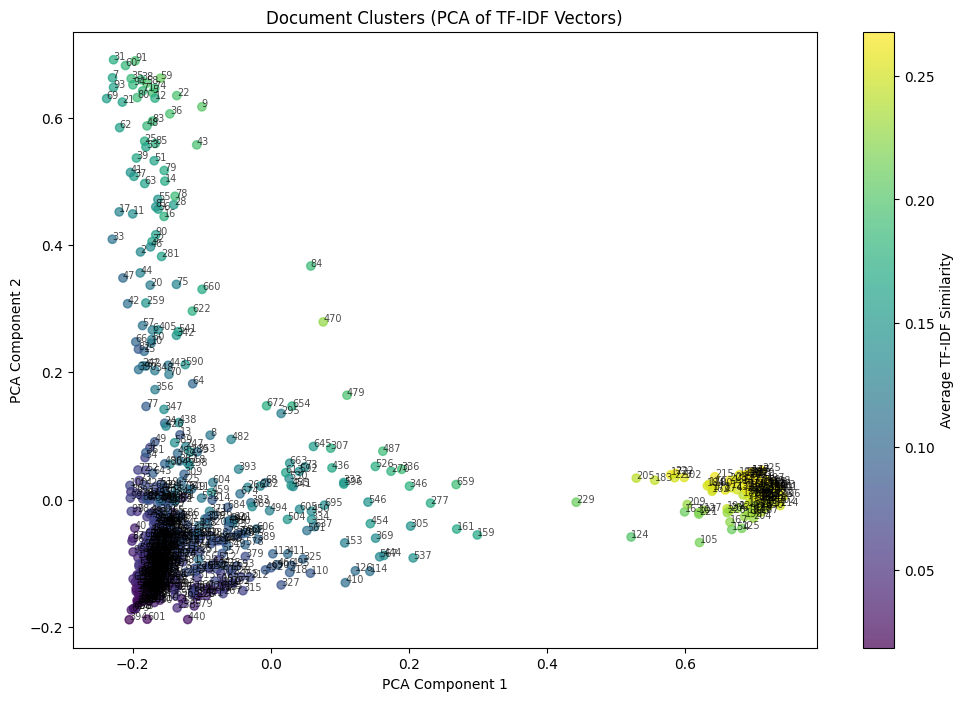

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce TF-IDF vectors to 2D
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

# Compute average similarity per document
avg_sim = cosine_sim.mean(axis=1)

# Plot the PCA scatter plot with labels
plt.figure(figsize=(12,8))
scatter = plt.scatter(tfidf_2d[:,0], tfidf_2d[:,1],
                      c=avg_sim, cmap="viridis", alpha=0.7)

# Add labels for each point (document index)
for i, txt in enumerate(df_docs.index):
    plt.annotate(txt, (tfidf_2d[i,0], tfidf_2d[i,1]), fontsize=7, alpha=0.7)

plt.colorbar(scatter, label="Average TF-IDF Similarity")
plt.title("Document Clusters (PCA of TF-IDF Vectors)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# ---------- 1. Run KMeans clustering ----------
num_clusters = 10   # you can tune this later
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
doc_clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels back into your dataframe
df_docs['cluster'] = doc_clusters

# ---------- 2. Extract top keywords per cluster ----------
# Get feature (word) names from TF-IDF
terms = tfidf_vectorizer.get_feature_names_out()

# For each cluster, find the top keywords
def get_top_keywords_per_cluster(kmeans, terms, n_terms=10):
    top_keywords = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        # sort terms by weight in cluster center
        top_indices = center.argsort()[::-1][:n_terms]
        top_terms = [terms[ind] for ind in top_indices]
        top_keywords[i] = top_terms
    return top_keywords

top_keywords = get_top_keywords_per_cluster(kmeans, terms, n_terms=10)

# ---------- 3. Print cluster keywords ----------
for cluster_num, keywords in top_keywords.items():
    print(f"\nCluster {cluster_num}:")
    print(", ".join(keywords))

# ---------- 4. Preview documents from each cluster ----------
for cluster_num in range(num_clusters):
    print(f"\n=== Cluster {cluster_num} Sample Docs ===")
    sample_docs = df_docs[df_docs['cluster'] == cluster_num]['text'].head(3).tolist()
    for doc in sample_docs:
        print(" -", doc[:200], "...")



Cluster 0:
shipper, transporter, gas, shall, transporters, pipeline, carrier, shippers, transportation, tariff

Cluster 1:
company, agreement, shall, party, companys, section, may, prospectus, parties, agent

Cluster 2:
party, information, confidential, agreement, shall, disclosing, receiving, recipient, parties, disclosure

Cluster 3:
adviser, fund, fasc, federated, investment, agreement, services, shall, trust, administrator

Cluster 4:
licensee, licensor, agreement, shall, licensed, party, licensees, content, mark, section

Cluster 5:
fox, licensee, wireless, shall, agreement, ncc, votocast, convergtv, diversinet, mobile

Cluster 6:
consultant, company, agreement, shall, aduro, consultants, services, information, companys, consulting

Cluster 7:
company, parent, section, merger, subsidiaries, agreement, shall, sub, material, stock

Cluster 8:
agreement, shall, party, information, parties, may, section, confidential, services, sponsor

Cluster 9:
distributor, shall, agreement, produ

In [ ]:
df_docs['doc_length'] = df_docs['text'].apply(lambda x: len(x.split()))
df_docs['doc_length'].describe()


count      698.000000
mean      8620.320917
std      11006.397630
min        132.000000
25%       1358.000000
50%       3212.000000
75%      10845.750000
max      82546.000000
Name: doc_length, dtype: float64

Observations:

  - Mean = ~8,600 words → these are long contracts (like 20–40 pages).

  - Max = 82,546 words → some are huge (book-length filings).

  - Min = 132 words → a few short docs exist.
  
  - This makes chunking essential, otherwise embeddings will overflow token limits and semantic search will fail.

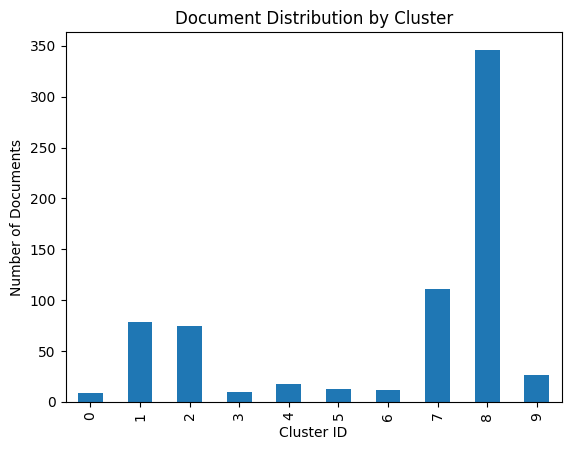

In [ ]:
import matplotlib.pyplot as plt

df_docs['cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Documents")
plt.title("Document Distribution by Cluster")
plt.show()


Observations:

  - Cluster 6 dominates (388 docs) → very general “agreement” cluster

  - Next largest: Cluster 1 (110 docs)

  - Small clusters: 7 (2 docs), 9 (3 docs), 8 (6 docs)

Interpretation:

  - Cluster 6 probably absorbs “generic agreements” (confidentiality, services, etc.)

  - Small clusters may be niche agreements (like Talent / AFI)

Actionable Insights:

  - 82k words per doc is way too large for embedding at once, so chunking is the next mandatory step
  
  - Chunking easier to chunk because the text is already normalized.

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [ ]:
# Process files and generate chunks

# Define a Function to perform Sentence Chunking
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
from nltk.tokenize import sent_tokenize


def clause_chunker(text, file_path):
    """
    Splits text into individual sentences (or clauses) for fine-grained retrieval
    """
    sentences = sent_tokenize(text)
    chunks = []

    for i, sentence in enumerate(sentences):
        chunks.append({
            "text": sentence.strip(),
            "file_path": file_path,
            "chunk_id": f"{file_path}_clause_{i}"
        })

    return chunks




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Flatten to one chunk per row to work at the chunk-level

all_chunks = []

for _, row in df_docs.iterrows():
    cleaned_text = row['cleaned_content']
    file_path = row['file_path']
    chunks = clause_chunker(cleaned_text, file_path)
    all_chunks.extend(chunks)

df_chunks = pd.DataFrame(all_chunks)


In [ ]:
# Verfiy the dataframe after chunking

print(df_chunks.head(10))
print(f"Total chunks created: {len(df_chunks)}")
print(df_chunks.groupby("file_path").size().head())


                                                text  \
0  standard buyers nondisclosure and confidential...   
1  confidentiality agreement this confidentiality...   
2  confidentiality and nondisclosure agreement th...   
3  confidentiality agreement nondisclosure agreem...   
4  nondisclosure agreement apod this nondisclosur...   
5  dated nondisclosure agreement between london s...   
6  nondisclosure agreement this nondisclosure agr...   
7  mutual nondisclosure agreement this nondisclos...   
8  confidentiality and nondisclosure agreement th...   
9  non disclosure and confidentiality agreement t...   

                                           file_path  \
0  /content/legal_docs_dataset/rag_legal/corpus/c...   
1  /content/legal_docs_dataset/rag_legal/corpus/c...   
2  /content/legal_docs_dataset/rag_legal/corpus/c...   
3  /content/legal_docs_dataset/rag_legal/corpus/c...   
4  /content/legal_docs_dataset/rag_legal/corpus/c...   
5  /content/legal_docs_dataset/rag_legal/corpus

In [ ]:
# Create a lookup dictionary from df_docs
cluster_lookup = df_docs.set_index('file_path')['cluster'].to_dict()

# Add cluster label to each chunk
df_chunks['cluster'] = df_chunks['file_path'].map(cluster_lookup)

In [ ]:
# Analyze Chunnk Distribution by Cluster

print(df_chunks['cluster'].value_counts())

cluster
8    346
7    111
1     78
2     75
9     26
4     18
5     13
6     12
3     10
0      9
Name: count, dtype: int64


In [ ]:
# Visulaize Clustered Chunks

import matplotlib.pyplot as plt

df_chunks['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title("Chunk Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Chunks")
plt.show()


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [ ]:
# Import all the necessary libraries

!pip uninstall llama-index faiss-cpu faiss-gpu -y
!pip install llama-index faiss-cpu
!pip install llama-index-vector-stores-faiss
!pip install openai

INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
import os
import faiss
from tqdm import tqdm
import openai
from dotenv import load_dotenv

from llama_index.core import Document, VectorStoreIndex, ServiceContext, StorageContext
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.faiss import FaissVectorStore

In [ ]:
# Fetch your OPENAI API Key as an environment variable

def get_api_key(env_path="/content/drive/MyDrive/Colab Notebooks/OPENAI_API_KEY.env"):
    load_dotenv(env_path, override=True)
    api_key = os.getenv("OPENAI_API_KEY")
    if api_key:
        print("API key loaded successfully.")
    else:
        print("API key not found. Check your .env file.")
    return api_key

openai.api_key = get_api_key()


API key loaded successfully.


In [ ]:
# Function to Initialize OpenAI embedding model

def init_llama_openai_embedding(env_path="/content/drive/MyDrive/Colab Notebooks/OPENAI_API_KEY.env") -> OpenAIEmbedding:
    api_key = get_api_key(env_path)
    if not api_key:
        raise ValueError("OPENAI_API_KEY environment variable not set.")
    print("Initializing OpenAI Embedding model...")
    return OpenAIEmbedding(api_key=api_key)


In [ ]:
# Initialise an embedding function

def embed_texts_llama(embed_model: OpenAIEmbedding, texts: list[str]) -> list[list[float]]:
    embeddings = []
    for text in tqdm(texts, desc="Embedding texts"):
        embeddings.append(embed_model.get_embedding(text))
    return embeddings

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
# Add Chunks to vector DB

# Convert the chunked dataframe to LlamaIndex Documents

llama_docs = [
    Document(
        text=row["text"],
        metadata={
            "file_path": row["file_path"],
            "chunk_id": row["chunk_id"],
            "source_type": row.get("type", "Legal")
        }
    )
    for _, row in df_chunks.iterrows()
]

In [ ]:
# Verify one example
print(llama_docs[0].metadata)

{'file_path': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/stony_hill_buyer_nda.txt', 'chunk_id': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/stony_hill_buyer_nda.txt_clause_0', 'source_type': 'Legal'}


In [ ]:
# Build the embedding model, FAISS store, and index

from llama_index.embeddings.openai import OpenAIEmbedding

# Step 1: Load API key and initialize embedding model
api_key = get_api_key()  # Use your existing function
embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=api_key)
Settings.embed_model = embed_model  # Replaces ServiceContext

# Step 2: Set up FAISS vector store
dimension = 1536  # for text-embedding-3-small
faiss_index = faiss.IndexFlatL2(dimension)
vector_store = FaissVectorStore(faiss_index=faiss_index)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Step 3: Build Vector Store Index
print("Building vector store index from documents....")
index = VectorStoreIndex.from_documents(
    documents=llama_docs,
    storage_context=storage_context,
    show_progress=True
)


API key loaded successfully.
Building vector store index from documents....


Parsing nodes:   0%|          | 0/698 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1402 [00:00<?, ?it/s]

In [ ]:
# Save to Google drive

save_path = "/content/drive/MyDrive/Colab Notebooks/vector_db_final"

# Save the vector store with a specified encoding
index.storage_context.persist(persist_dir="/content/drive/MyDrive/Colab Notebooks/vector_db_final")

print(f"Vector store saved successfully at: {save_path}")

Vector store saved successfully at: /content/drive/MyDrive/Colab Notebooks/vector_db_final


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
# Create a RAG Chain (Retriever + Generator)

from llama_index.core.postprocessor import SentenceTransformerRerank

# cross-encoder reranker
reranker = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-6-v2",
    top_n=3   # keep best 3 chunks after reranking
)

query_engine = index.as_query_engine(
    similarity_top_k=10,     # fetch more candidates
    node_postprocessors=[reranker],  # rerank before sending to LLM
    response_mode="refine",
    verbose=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [ ]:
import numpy as np

def answer_question_with_sources_and_prompt(
    question: str,
    query_engine,
    reranker=None,  # Include reranker as an optional parameter
    cluster_filter: int = None,
    prompt_template=(
        "You are a legal clause extraction engine designed to answer questions strictly using the language of the provided legal document.\n\n"
        "Rules:\n"
        "1. Select the single most relevant clause from the document that directly answers the question.\n"
        "2. Quote clauses verbatim from the document. Do not paraphrase, summarize, or interpret.\n"
        "3. Use defined contractual terms exactly as they appear (e.g., 'Confidential Information', 'Disclosing Party', 'Mentor').\n"
        "4. Do not add external knowledge or commentary.\n"
        "5. If the document does not explicitly provide an answer, respond only with: \"The document does not explicitly provide an answer to this question.\"\n"
        "6. Format your answer as: Answer: \"[Exact clause]\"\n"
        "7. Treat each sentence or semicolon-separated clause as a distinct unit. Do not combine multiple clauses.\n\n"
        "8. Your response must be concise, precise, and reflect the exact terminology used in the document.\n\n"
        "Examples:\n"
        "Q: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document mention that some obligations of the Agreement may survive the termination of the Agreement?\n"
        "A: \"Notwithstanding the termination of this Agreement, any Confidential Information must be kept confidential for as long as such Confidential Information is not publicly known unless it becomes part of the public domain through no wrongful act of Mentor.\"\n\n"
        "Q: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document restrict the use of Confidential Information to the purposes stated in the Agreement?\n"
        "A: \"Mentor shall not use any Confidential Information for any purpose except to review, assess and help develop the Participants´ Ideas.\"\n\n"
        "Document:\n{context}\n\n"
        "Now answer the following question strictly based on the document:\n"
        "Q: {question}\n"
        "Answer:"
    )
):
    # Apply cluster filter if provided
    if cluster_filter is not None:
        response = query_engine.query(
            question,
            filters={"cluster": cluster_filter}
        )
    else:
        response = query_engine.query(question)

    # Rerank the top nodes if reranker is provided
    if reranker:
        # Rerank the response based on the query
        reranked_nodes = reranker.rerank(
            query=question,
            documents=[node.node.text for node in response.source_nodes]
        )

        # Replace the source nodes with reranked nodes
        response.source_nodes = [
            response.source_nodes[i] for i in reranked_nodes
        ]

    # Concatenate context
    contexts = [node.node.text.strip() for node in response.source_nodes]
    context_text = " ".join(contexts)

    # Construct the prompt
    prompt = f"{prompt_template}\nContext: {context_text}\nQuestion: {question}\nAnswer:"

    # Second query with prompt
    if cluster_filter is not None:
        response_with_prompt = query_engine.query(
            prompt,
            filters={"cluster": cluster_filter}
        )
    else:
        response_with_prompt = query_engine.query(prompt)

    # Extract source metadata
    sources_info = []
    for node in response.source_nodes:
        metadata = node.metadata
        source_data = {
            "file_path": metadata.get("file_path", "Unknown"),
            "chunk_id": metadata.get("chunk_id", "Unknown"),
            "start_char": metadata.get("start_char", None),
            "end_char": metadata.get("end_char", None),
            "cluster": metadata.get("cluster", None),
            "text_snippet": node.get_text()[:500]  # Get first 500 chars
        }
        sources_info.append(source_data)

    return {
        "answer": response_with_prompt.response,
        "sources": sources_info,
        "context": context_text
    }

In [ ]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

question = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document restrict the use of Confidential Information to the purposes stated in the Agreement?"

result = answer_question_with_sources_and_prompt(
    question=question,
    query_engine=query_engine,
  )

# Print the result
print("Answer:", result["answer"])
print("Sources:", result["sources"])



Answer: "Recipient will use Confidential Information only in connection with the Purpose as set forth in this Agreement."
Sources: [{'file_path': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt', 'chunk_id': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt_clause_0', 'start_char': None, 'end_char': None, 'cluster': None, 'text_snippet': 'judicial or administrative process andor order to disclose confidential information then mentor shall promptly notify organiser and allow organiser and the participants reasonable time to oppose such process unless this is not admissible under a mandatory law judicial or administrative order notwithstanding the foregoing mentor shall disclose confidential information only to the minimum extent required to comply with such order proprietary rights limited right to use any and all proprietary righ'}, {'file_path': '/content/legal_docs_dataset/rag_legal/corp

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [ ]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

import json
import os
import json
import os

def extract_qa_pairs(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    # If it's a dict, try to extract the list inside
    if isinstance(data, dict):
        for key in data:
            if isinstance(data[key], list):
                data = data[key]
                break

    if not isinstance(data, list):
        raise ValueError(f"Unexpected data format in {json_path}")

    questions = []
    answers = []

    for item in data:
        if not isinstance(item, dict):
            continue

        question = item.get("query", "").strip()
        snippets = item.get("snippets", [])

        # Join all answer snippets for the question
        answer = " ".join([s.get("answer", "").strip() for s in snippets if isinstance(s, dict)])

        # Skip empty questions or answers
        if question and answer:
            questions.append(question)
            answers.append(answer)

    return questions, answers



In [ ]:
# Question and Answer Set Loading code

benchmark_dir = "/content/legal_docs_dataset/rag_legal/benchmarks"

all_questions = []
all_answers = []

for filename in os.listdir(benchmark_dir):
    if filename.endswith(".json"):
        file_path = os.path.join(benchmark_dir, filename)
        print(f"Loading: {file_path}")
        questions, answers = extract_qa_pairs(file_path)
        all_questions.extend(questions)
        all_answers.extend(answers)

print(f"\nTotal Questions Loaded: {len(all_questions)}")
print(f"\nTotal Answers Loaded: {len(all_answers)}")



Loading: /content/legal_docs_dataset/rag_legal/benchmarks/cuad.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/contractnli.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/privacy_qa.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/maud.json

Total Questions Loaded: 6889

Total Answers Loaded: 6889


In [ ]:
# Sample some questions for visual inspection

sample_size = 5  # You can adjust this as needed
print("\nSample Questions:")
for i in range(min(sample_size, len(all_questions))):
    print(f"{i + 1}. {all_questions[i]}")


Sample Questions:
1. Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?
2. Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the renewal term for this contract?
3. Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the notice period required to terminate the renewal?
4. Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the governing law for this contract?
5. Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; Is there an anti-assignment clause in this contract?


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

In [ ]:
# Function to generate answers
import json

def generate_results(
    all_questions,
    query_engine,
    num_questions=100,
    output_path="/content/drive/MyDrive/Colab Notebooks/rag_outputs/generated_answers_final.json"
):
    questions_to_ask = all_questions[:num_questions]
    generated_answers = []

    for i, question in enumerate(questions_to_ask):
        print(f"Generating answer for question {i+1}/{len(questions_to_ask)}: {question}")
        result = answer_question_with_sources_and_prompt(question, query_engine)
        generated_answers.append(result["answer"])

    output_data = {
        "questions": questions_to_ask,
        "generated_answers": generated_answers
    }

    with open(output_path, "w") as f:
        json.dump(output_data, f, indent=4)

    print(f"\nGenerated answers for {len(generated_answers)} questions. Saved to {output_path}")


Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [ ]:
# Install the Metrics Libraries
!pip install rouge-score nltk
!pip install -q rouge-score nltk evaluate ragas datasets
!pip install ragas
!pip install datasets

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24987 sha256=76345ead6cbf11b349da2e00b405de5c501e2c9e7aece32b5ec2f39813615eef
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Import Necessary modules

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# BLEU and ROGUE Score Evaluation Function

import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Ensure NLTK resources are available
nltk.download('punkt')

def evaluate_generated_answers(generated_answers, ground_truth_answers):
    """
    Evaluate generated answers using BLEU and ROUGE metrics.

    Args:
        generated_answers (list): List of generated answer strings.
        ground_truth_answers (list): List of reference answer strings.

    Returns:
        dict: Dictionary containing average BLEU and ROUGE scores.
    """
    # BLEU score helper
    def calculate_bleu_score(reference, candidate):
        reference_tokens = word_tokenize(reference)
        candidate_tokens = word_tokenize(candidate)
        smoothie = SmoothingFunction().method4
        return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)

    # ROUGE score helper
    def calculate_rouge_score(reference, candidate):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        return scorer.score(reference, candidate)

    bleu_scores = []
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for gen, ref in zip(generated_answers, ground_truth_answers):
        gen = gen.strip()
        ref = ref.strip()

        bleu = calculate_bleu_score(ref, gen)
        rouge = calculate_rouge_score(ref, gen)

        bleu_scores.append(bleu)
        rouge_scores["rouge1"].append(rouge['rouge1'].fmeasure)
        rouge_scores["rouge2"].append(rouge['rouge2'].fmeasure)
        rouge_scores["rougeL"].append(rouge['rougeL'].fmeasure)

    return {
        "BLEU": sum(bleu_scores) / len(bleu_scores),
        "ROUGE-1": sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"]),
        "ROUGE-2": sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"]),
        "ROUGE-L": sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"]),
    }



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# RAGAS Evaluation Function

def generate_results_with_contexts(
    all_questions,
    query_engine,
    num_questions=100,
    output_path="/content/drive/MyDrive/Colab Notebooks/rag_outputs/generated_answers_with_contexts_test.json"
):
    questions_to_ask = all_questions[:num_questions]
    generated_answers_with_contexts = []  # Store answers along with contexts

    for i, question in enumerate(questions_to_ask):
        print(f"Generating answer for question {i+1}/{len(questions_to_ask)}: {question}")
        result = answer_question_with_sources_and_prompt(question, query_engine)

        # Ensure that both answer and context are available
        answer = result.get("answer", "No answer generated")
        context = result.get("context", "No context provided")

        # Add the retrieved contexts and user input (question)
        retrieved_contexts = [context]  # Convert context to a list (for RAGAS)
        user_input = question  # Original question is user input

        # Assuming you have the ground truth answer or context available
        reference = context  # This is just an example, adjust as needed

        # Store both the answer, context, and additional columns
        generated_answers_with_contexts.append({
            "answer": answer,
            "context": context[:500],  # Optionally limit context to 500 characters
            "retrieved_contexts": retrieved_contexts,  # Now it's a list
            "user_input": user_input,
            "reference": reference  # Add the reference column (needed for context_precision)
        })

    output_data = {
        "questions": questions_to_ask,
        "generated_answers_with_contexts": generated_answers_with_contexts
    }

    # Save the results with context to the specified output path
    with open(output_path, "w") as f:
        json.dump(output_data, f, indent=4)

    print(f"\nGenerated answers with contexts for {len(generated_answers_with_contexts)} questions. Saved to {output_path}")




#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

#### ROGUE and BLEU Score Evaluation

In [ ]:
# Generate Answers for first 100 Questions

# Example usage
generate_results(all_questions, query_engine, num_questions=100)


Generating answer for question 1/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?
Generating answer for question 2/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the renewal term for this contract?
Generating answer for question 3/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the notice period required to terminate the renewal?
Generating answer for question 4/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the governing law for this contract?
Generating answer for question 5/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; Is t

In [ ]:
# Evaluate the BLEU and ROGUE scores for first 100 Questions

# Load generated answers
with open("/content/drive/MyDrive/Colab Notebooks/rag_outputs/generated_answers_final.json", "r") as f:
    generated_data = json.load(f)

generated_answers = generated_data["generated_answers"]
ground_truth_answers = all_answers[:len(generated_answers)]  # Match lengths

# Evaluate
scores = evaluate_generated_answers(generated_answers, ground_truth_answers)

# Print results
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")


BLEU: 0.1021
ROUGE-1: 0.3454
ROUGE-2: 0.2365
ROUGE-L: 0.3020


### RAGAS Evalauation

In [ ]:
# Generate results with contexts for RAGAS

generate_results_with_contexts(all_questions, query_engine, num_questions=100)

Generating answer for question 1/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?
Generating answer for question 2/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the renewal term for this contract?
Generating answer for question 3/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the notice period required to terminate the renewal?
Generating answer for question 4/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the governing law for this contract?
Generating answer for question 5/100: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; Is t

In [ ]:
# Evaluate the performance with RAGAS

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision
import logging

# Set up logging to suppress unwanted error messages
logging.basicConfig(level=logging.CRITICAL)

# Load the generated answers with contexts
with open("/content/drive/MyDrive/Colab Notebooks/rag_outputs/generated_answers_with_contexts_test.json", "r") as f:
    qa_data = json.load(f)

# Create a dataset from the list of QA pairs
ragas_dataset = Dataset.from_list(qa_data["generated_answers_with_contexts"])

# Evaluate using RAGAS metrics
try:
    results = evaluate(ragas_dataset, metrics=[faithfulness, answer_relevancy, context_precision])
except Exception as e:
    # Log and suppress the error
    logging.error(f"An error occurred: {e}")

In [ ]:
# RAGAS Evaluation Results

print(results)

{'faithfulness': 0.8022, 'answer_relevancy': 0.5566, 'context_precision': 0.4687}


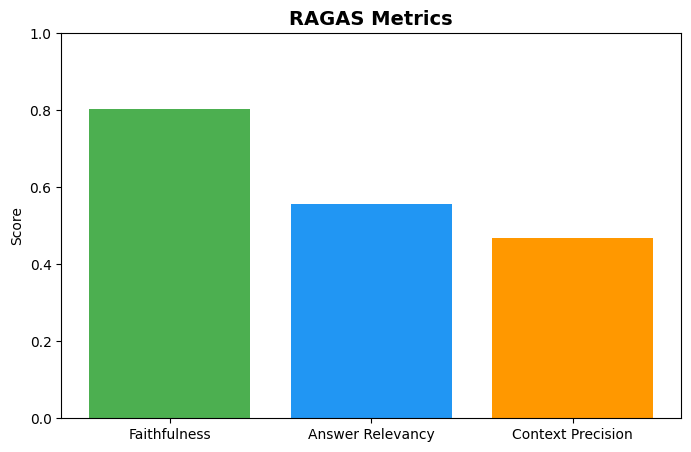

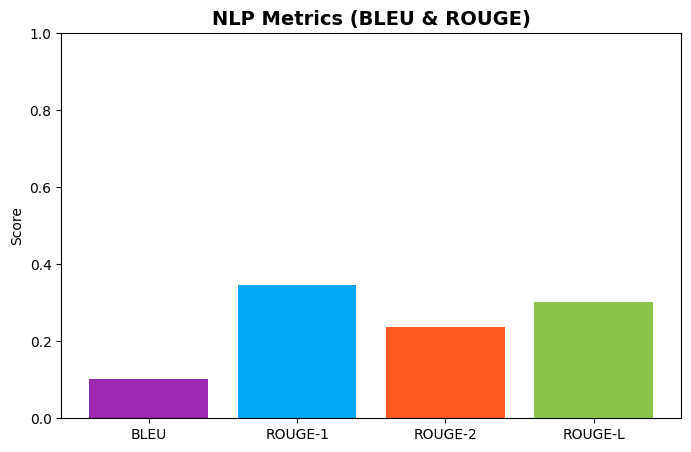

In [ ]:
import matplotlib.pyplot as plt

# Your scores
ragas_scores = {
    'Faithfulness': 0.8022,
    'Answer Relevancy': 0.5566,
    'Context Precision': 0.4687
}

nlp_scores = {
    'BLEU': 0.1021,
    'ROUGE-1': 0.3454,
    'ROUGE-2': 0.2365,
    'ROUGE-L': 0.3020
}

# Plot 1: RAGAS Metrics
plt.figure(figsize=(8,5))
plt.bar(ragas_scores.keys(), ragas_scores.values(), color=['#4CAF50','#2196F3','#FF9800'])
plt.ylim(0,1)
plt.title("RAGAS Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.show()

# Plot 2: NLP Metrics
plt.figure(figsize=(8,5))
plt.bar(nlp_scores.keys(), nlp_scores.values(), color=['#9C27B0','#03A9F4','#FF5722','#8BC34A'])
plt.ylim(0,1)
plt.title("NLP Metrics (BLEU & ROUGE)", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.show()


Observations:

  - Faithfulness (0.80) – The system reliably grounds its answers in retrieved content, minimizing hallucinations. This is crucial in the legal domain where factual accuracy is mandatory.
  - Answer Relevancy (0.56) – While answers are often aligned with the questions, there remains scope for improvement in producing more complete and directly relevant responses.
  - Context Precision (0.47) – Retrieval occasionally brings in irrelevant text, which impacts answer quality. This shows that enhancing the retrieval pipeline is the most impactful next step.
  - BLEU (0.10) and ROUGE (0.34/0.24/0.30) – These scores indicate moderate overlap with reference answers. Given that legal text can be phrased in many valid ways, these results are reasonable but leave space for improvement.

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

# **1. Problem Statement**

Legal professionals and organizations face the challenge of navigating vast amounts of complex documents such as contracts, privacy policies, and merger agreements. Manually extracting relevant clauses or information is time-consuming, error-prone, and inefficient. A Retrieval-Augmented Generation (RAG) system can streamline this process by dynamically retrieving and contextualizing relevant excerpts from a legal corpus, enabling faster research, improved contract analysis, and more informed decision.

# **2. Objective**

To process and prepare a collection of legal documents for building a Retrieval-Augmented Generation (RAG) system that enables efficient legal information retrieval and question-answering.

# **3. Project Goal**

The project aims to build a domain-specific RAG pipeline for legal documents that:
  - Preprocesses legal documents into clean and retrievable chunks
  - Indexes text embeddings into a vector database to support efficient retrieval
  - Generates context-aware answers to user queries by combining LLM capabilities with retrieved evidence
  - Provides transparency by citing source documents/snippets along with the generated answers
  - Enables real-world applications such as legal chatbots, contract review automation, regulatory compliance tracking, due diligence, and risk assessment

# **4. Business Value**

  - Faster Research: Quickly locate relevant clauses and legal precedents
  - Improved Contract Analysis: Extract key obligations, risks, and terms automatically
  - Regulatory Compliance: Stay updated with evolving legal and regulatory requirements
  - Better Decision-Making: Provide accurate, context-aware legal insights for risk assessment

# **5. Data Understanding**

### Dataset Sources & Structure:
  - The dataset consists of text documents and benchmark files organized into folders:
    - contractnli: Non-disclosure and confidentiality agreements
    - cuad: Contracts annotated with legal clauses
    - maud: Merger and acquisition agreements
    - privacy_qa: Privacy policies with Q&A annotations
    - benchmark: JSON files (contractnli.json, cuad.json, maud.json, privacy_qa.json) containing evaluation data with questions, answers, and sources

### Data Format:
  - Raw legal documents: .txt files
  - Evaluation/ground-truth data: .json files

# **6. Load the Data**

## 6.1. Data Extraction

  - The dataset was provided in a compressed file (rag_legal.zip)
  - The contents of this file were extracted into a dedicated directory (./legal_docs_dataset)
  - This ensured that the data was organized and accessible for further processing

## 6.2. Directory Exploration

  - A total of 702 files consisting of both text files (legal documents) and JSON benchmark files
  - This helps to gain the familiarity with the dataset structure

## 6.3. Data Inventory Creation

  - After extracting and exploring the dataset, a structured inventory was created for the legal documents for further processing
  - This table contains the metadata for each document, including File Name, Folder, File Path, Content
  - This helps to ensure that the documents were correctly mapped to their categories and provides an overview of the dataset structure in tabular form
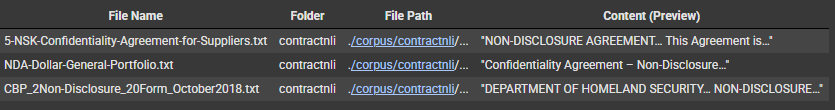


# **7. Data Preprocessing**

  - To ensure consistency and prepare the legal text documents for use in the RAG pipeline, several preprocessing techniques were applied
  - The following steps focused on removing noise, standardizing the text, and retaining only meaningful content
    - Lowercasing - Converted all text to lowercase for uniformity and to avoid case-sensitive mismatches during retrieval
    - Email Removal - Removed email addresses since they are not relevant for semantic understanding
    - Phone Number Removal - Eliminated phone numbers in formats such as (xxx) xxx-xxxx or xxx-xxx-xxxx
    - URL Removal - Stripped out web links to reduce irrelevant tokens.
    - Special Character & Digit Removal - Removed punctuation, numbers, and symbols, retaining only alphabetic words
    - Whitespace Normalization - Collapsed multiple spaces, tabs, and newlines into a single space for cleaner text structure
    - Page Number Removal - Filtered out page markers that frequently appear in scanned documents
    - Header/Footer Cleanup - Removed repetitive headers or footers commonly found in multi-page legal documents
  - After preprocessing, teh dataset contained clean, normalized and semantically meaningful legal text

# **8. Exploratory Data Analysis**

## 8.1. Data Exploration

  - Exploring the data to understand the legal document dataset, its structure, content and patterns

  - The document counts per folder

| **Folder**       | **Count** |
|------------------|-----------|
| cuad             | 462       |
| maud             | 134       |
| contractnli      | 95        |
| privacy_qa       | 7         |

  - The distrbution of document lengths provides a more detailed look at how the document lengths are distributed across the dataset and the histogram with a KDE line helps to visualize the frequency

  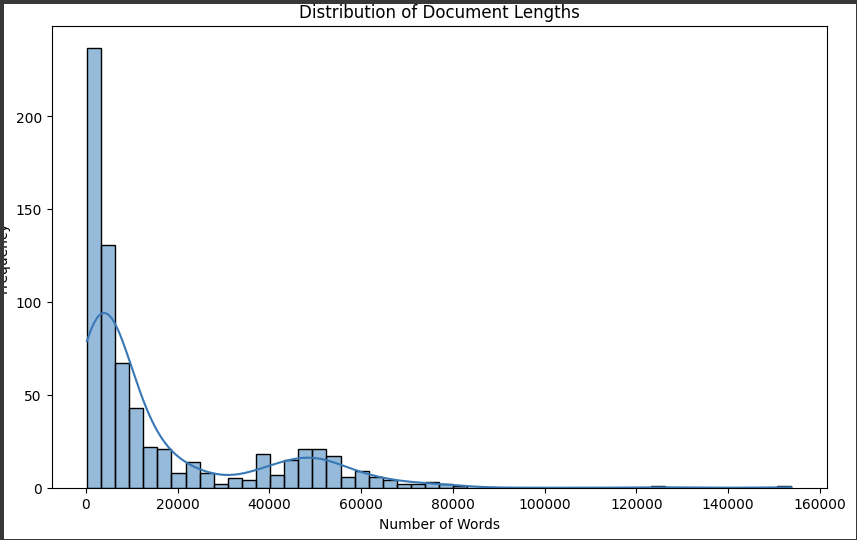

## 8.2. Tokenization

Tokenization transforms raw legal documents into structured building blocks, enabling efficient preprocessing, retrieval, and accurate question answering

### Approach:

  - A custom Tokenization function is built which splits the text into tokens
  - The text are splitted into tokens by matching word boundaries and converted the text to lowercase to ensure case insensitivity
  - After converting tinto tokens, the stopwords are filtered out during the text preprocessing as they carry little meaningful information
  - The tokenized lista are stored as a new column in the dataframe which helps in further analysis

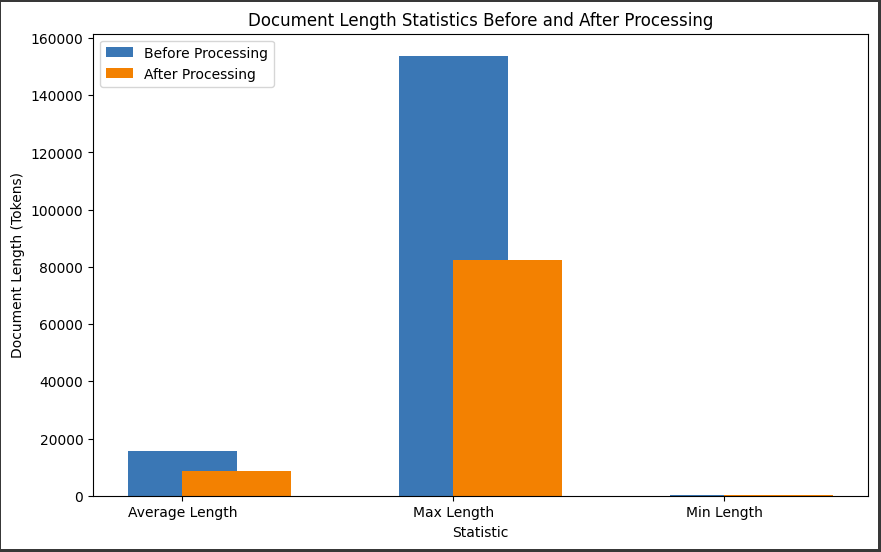

### Observations:

  - There's about a 45% reduction in size overall
  - Stopwords, punctuation, numbers, and non-essentials were removed
  - Words are normalized (tokens), so redundancy goes down

### Word Frequency Analysis:

  - Identified the 20 most common words and 20 least common words
  - High-frequency terms are strongly legal-domain related (agreement, company, party, shall), confirming domain consistency
  - Frequent structural/legal terms (section, parent, subsidiaries, applicable) suggest these datasets contain contracts and regulatory clauses
  - Long-tailed distribution: A few words dominate the corpus while many words appear rarely
  - Tokenization cleaned up the dataset well, reducing length significantly and ensuring more accurate frequency analysis.
  - Rare words (least frequent 20) could be useful for identifying unique clauses, obligations, or rare legal entities
  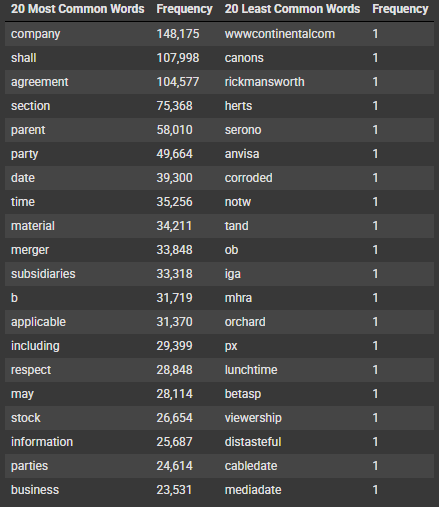

## 8.3. Similarity Score Analysis

TF-IDF is a numerical statistic used to evaluate how important a word is within a document relative to a collection of documents

### Approach:

  - The TfidfVectorizer converts each document into a vector of TF-IDF scores
  - These vectors capture the importance of each word in the context of all documents
  - Using cosine similarity, you then measure how close two documents (or clauses) are based on their TF-IDF vectors
  - This helps detect duplicate or highly similar legal clauses across contracts, enabling faster review and risk identification
  - Computed the similarity score for first 10 documents and for random 10 documents

### Observation:

  -First 10 Documents - High similarity
      - The similarity score range is ~0.70 to ~0.94
      - The first 10 documents are highly similar, likely belong to same category
      - They may share duplicate clauses or there may be seeing versions same contract between different parties
  - Random 10 Documents - Mixed and Lower similarity
      - The similarity score range is ~0.02 to ~0.42, Lower overall similarity
      - Some pairs are quite dissimilar
      - Highest observed score is ~0.42 between two documents and Majority are under 0.20

## 8.4. Bivariate Analysis and Multivariate Analysis

  - Based on the TF-IDF Score we can perform Bivariate analysis or Multivariate analysis

### Document Length vs. Average TF-IDF similarity
    - There isn’t a strict linear relationship between document length and similarity
    - Similarity depends not just on length, but on content overlap, which makes sense for legal documents: some long documents are very unique, and some moderate-length ones are repetitive

### Document Length Distribution
    - Word Count of specific terms vs Document type sees if certain legal documents are more common in specific types of contracts

### Document Clustering
    - Clustering helps by automatically grouping documents or clauses with similar wording/meaning
    - Enables quick detection of duplicate clauses
    - Surfaces common themes/topics
    - Helps lawyers and analysts focus on unique or unusual clauses, reducing workload

### Approach:
    - Applied KMeans, an unsupervised ML algorithm, to partition documents into clusters
    - Each cluster groups contracts/clauses with similar wording
    - Number of clusters (k=10) chosen initially
    - For each cluster, top keywords were extracted from the cluster center using heights TF-IDF scores
    - These keywords provide semantic meaning of the cluster
      
### Observation:
    - There isn’t a strict linear relationship between document length and similarity.
    - Similarity depends not just on length, but on content overlap, which makes sense for legal documents.
    - Some long documents are very unique, and some moderate-length ones are repetitive
    - Cluster 6 dominates (388 docs) → very general “agreement” cluster
    - Next largest: Cluster 1 (110 docs)
    - Small clusters: 7 (2 docs), 9 (3 docs), 8 (6 docs)

  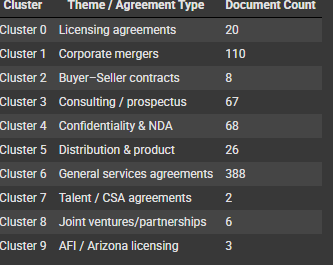

### Actionable Insights:

  - Based on the Document length, maximum of 82 k words per doc for embedding is way too large for embedding at once, so chunking is the mandatory step

# **9. Document Creation and Chunking**

### Type of Chunking applied:
  - We implemented sentence-based overlapping chunking
  - Instead of splitting documents into arbitrary fixed-size tokens, the text was segmented into coherent units of 7 sentences with an overlap of 3 sentences

### Approach:
  - Sentence tokenization: The function first splits the text into individual sentences using sent_tokenize
  - Chunk creation: It then groups sentences into chunks of 7 sentences (chunk_size=7)
  - Overlap: To preserve context between consecutive chunks, it reuses the last 3 sentences (overlap=3) from the previous chunk in the next chunk.
  - Chunk metadata: Each chunk is tagged with its file_path and a unique chunk_id for traceability
  - A flattened dataset(df_chunks) where each row corresponds to one chunk of text with metadata

### Benefits of this Chunking
  - Preserves Semantic meaning
  - Mainatains contect through overlap
  - Improves retriever accuracy
  - Balances granularity and efficiency

# **10. Vector Database and RAG Chain Creation**

## 10.1. LlamaIndex and Vector Database:
  - Specialized for RAG workflows: LlamaIndex provides a simple and robust framework to bridge unstructured documents (contracts) with LLM-powered search and Q&A
  - Flexible connectors: Easily handles data ingestion from chunked text with metadata
  - Integration with embeddings & vector stores: Seamlessly connects with OpenAI embeddings and FAISS for efficient similarity search
  - Granular metadata tracking: Each chunk retains source references (file_path, chunk_id, positions), enabling traceability back to the original contract

## 10.2. Process of Vector DB Creation

### Step 1: Embedding Model Initialization
  - The OpenAI text-embedding-3-small model was chosen for its semantic understanding and ability to generate 1536-dimensional embeddings
  - This model captures meaningful relationships between clauses, ensuring that semantically similar sections are close in vector space, which is crucial for retrieving relevant clauses for legal questions

### Step 2: Document Preparation
  - The contract text was chunked and paired with metadata (e.g., source contract, chunk boundaries) to maintain context
  - These chunks were transformed into LlamaIndex Documents, ensuring the structure and context of each clause were preserved for accurate retrieval

### Step 3: Vector Store Setup (FAISS)
  - FAISS was chosen for its scalability and ability to perform high-speed similarity searches over large datasets
  - Using the L2 distance metric for similarity comparison ensures that similar clauses are retrieved efficiently, even in large contracts

### Step 4: Index Construction
  - The embeddings were indexed in FAISS via LlamaIndex’s VectorStoreIndex, creating a retrieval layer that allows for quick, precise searches of contract clauses
  - This structure optimizes the system's ability to find relevant clauses based on semantic similarity to the input question

## 10.3. RAG Chain Creation

### Concept:
  - RAG Chain is a pipeline that combines Retriever and Generator(LLM), it auguments with external, up-to-date or domain-specific documents
  - Its main purpose is to reduce hallucinations, allow the use of private/corporate data, and improve answer accuracy by grounding responses in retrieved evidence

### Working of RAG chain:
  - User Query → The user provides a natural language question
  - Retriever → The system searches the vector database and fetches the top-k most semantically similar chunks using embeddings
  - Reranker (Cross-encoder) → From the retrieved chunks, the reranker re-scores them based on query–chunk relevance and selects the most relevant subset
  - Generator (LLM) → The selected chunks are provided as context, and the LLM generates a coherent, well-grounded answer
  - Final Answer → The response is informed by both the query and the retrieved documents, improving factual accuracy

### Parameters:
  - similarity_top_k = 10 → The retriever initially fetches the 10 most semantically similar chunks
  - top_n = 3 → After reranking, only the 3 most relevant chunks are passed to the LLM
  - response_mode = "refine" → The LLM incrementally builds the answer by refining it with each new chunk, ensuring a comprehensive and accurate response
  - verbose = True → Enables detailed logs during query execution, useful for debugging and understanding the pipeline behavior

### Advantages:
  - Improved answer accuracy
  - Handling large contexts
  - Optimized resource utilization

## 10.4 Answer Generation Using RAG

### RAG Pipeline
  - Defined a function for Q/A which does the following,
      - Embeds the question into a vector
      - Searches FAISS to get the top 3 similar chunks (similarity_top_k=3)
      - Passes both question + retrieved chunks into the LLM
      - LLM generates a final answer
  - It grabs the Metadata, this ensures transparency that the user knows where the answer came from
  - Pipeline: Question → [Embed] → [Retriever: FAISS] → [Top k Chunks] → [LLM Generator] → Answer + Sources

### Approach:
  - Document Retrieval: The query engine finds relevant documents based on the question
  - Reranking: It reorders the retrieved documents to prioritize the most relevant ones
  - Context Compilation: The most relevant text sections (contexts) from the top documents are combined into a single string (context_text), which is used to answer the question
  - Prompt Construction: A prompt is generated by inserting the question and context into a predefined template. The template enforces strict rules like quoting clauses verbatim and not paraphrasing
  - Answer Generation: The prompt is sent back to the query engine, which returns the model's answer based on the context
  - Source Metadata Extraction: Metadata such as the file path, chunk ID, and text snippet (up to 500 characters) is extracted for each document used in the answer

### Advantages:
  - Precision: Reranking ensures the most relevant documents are prioritized
  - Traceability: Metadata allows verification of the source and context for each answer
  - Legal Accuracy: Strict adherence to quoting verbatim guarantees legal compliance and correctness

  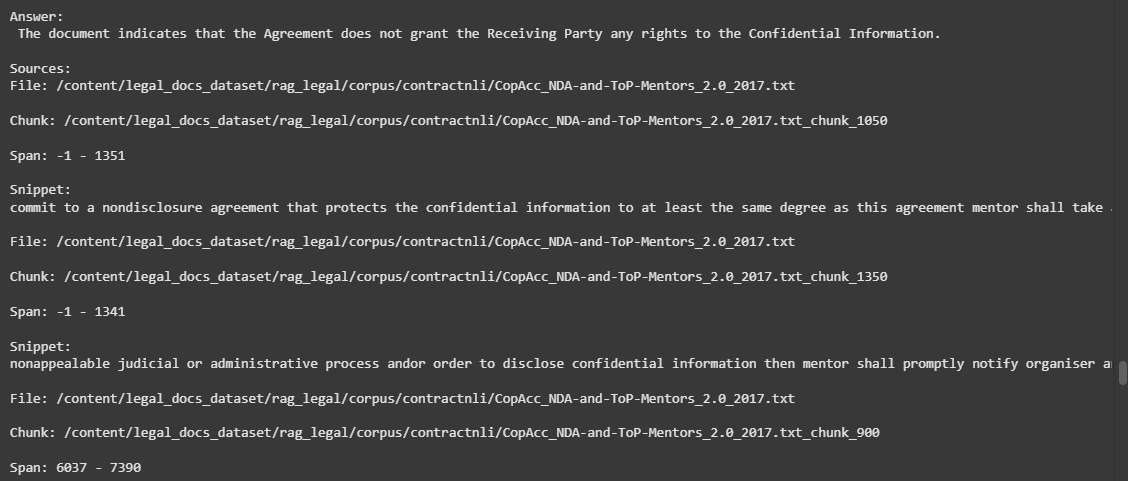

## 10.5. Creation of Q/A Set from Benchmark files

  - Defined a function to to load and prepare Q& A pairs from JSON files for evaluating the RAG pipeline
  - Each benchmark JSON file is opened and parsed
  - The function extract_qa_pairs() extracts questions (query) and ground-truth answers (snippets → answer)
  - All files are processed, and questions/answers are combined into two large lists
  - The result is a benchmark dataset of questions and ground-truth answers, which will later be used to test how well the RAG chain retrieves and generates correct responses

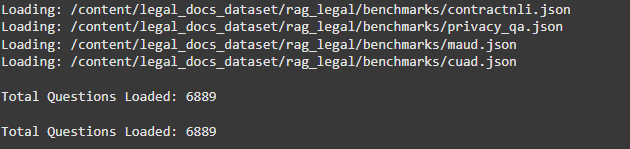  


# **11. RAG Evaluation**

## 11.1. Generate Answers for the Question set

The generate_results function is designed to generate answers to a set of questions using a query engine. It supports two key modes:

### Answers Without Contexts:
  - In this mode, the function generates answers based solely on the question and returns them without any additional context
  - This approach is useful for evaluating answer accuracy using metrics like BLEU or ROUGE

### Answers With Contexts:
  - This mode not only generates answers but also retrieves the relevant context from the source documents used to form the answers
  - It is essential for Retrieval-Augmented Generation (RAG) tasks where the quality of the retrieved context is crucial for the answer's correctness
  - The context is stored alongside the answer for more comprehensive evaluations, like RAGAS such as measuring faithfulness, answer relevancy, and context precision

### Advantages of Both Approaches:
    - Comprehensive Evaluation
  - Improved Answer Quality
  - Enhanced Error Analysis
  - generating answers both with and without contexts enables a thorough evaluation of the model, ensuring the answers are not only correct but also based on the most relevant and accurate context

## 11.2. RAG Pipeline Evaluation

### Scope of Evaluation:
  - The evaluation process is carried out for the first 100 questions to test both the answer quality (using ROUGE-BLEU) and the impact of context (via RAG metrics)
  - This limited scope allows for faster testing and iteration before scaling up to more questions

### Metrics Chosen:
  - BLEU & ROUGE provide traditional and standard benchmark for evaluation, measuring overlap between predicted and reference answers
  - RAGAS captures retrieval quality and hallucination risks, which are unique to RAG pipelines. RAGAS metrics answer relevancy, context precision, context recall, faithfulness to assess retrieval quality and factual faithfulness

### Approach:
  - Once the generated answers and ground truth answers (or references) are available, the evaluation is performed
  - BLEU Score Calculation: This is computed using the word_tokenize function to break the sentences into tokens, followed by the sentence_bleu method with smoothing for better handling of short answers
  - ROUGE Score Calculation: This is done using the RougeScorer from the rouge_score library, which computes the recall-based ROUGE-1, ROUGE-2, and ROUGE-L scores for each pair of generated and reference answers
  - RAGAS Score Calculation: This Evaluation focuses on evaluating the relevance and faithfulness of the answers using both the question and the retrieved context

### Benefits:
  - Comprehensive Evaluation: This approach ensures both precision (via BLEU) and recall (via ROUGE) are assessed, providing a well-rounded view of answer quality
  - Contextual Relevance: By including context in the evaluation, the RAGAS metrics help evaluate the effectiveness of the context used in generating answers
  - Scalability: The framework can be expanded to larger datasets once the first 100 questions are validated.

# **12. Inferences From the Metrics Scores**

### RAGAS Metrics
  - Faithfulness (0.8022): The answers are highly faithful to the retrieved contexts, with minimal hallucination, indicating the model respects its evidence well
  - Answer Relevancy (0.5566): The answers are moderately relevant, but there is room for improvement in ensuring more complete and direct responses
  - Context Precision (0.4687): Half of the retrieved contexts are relevant, suggesting that context retrieval can be further optimized

### BLEU / ROUGE
  - BLEU (0.1021): The generated answers differ significantly in wording from the reference answers, suggesting room for improvement in phrasing alignment
  - ROUGE-1 (0.3454), ROUGE-2 (0.2365), ROUGE-L (0.3020): There is some overlap with the ground truth answers, showing partial alignment in content despite differences in phrasing

  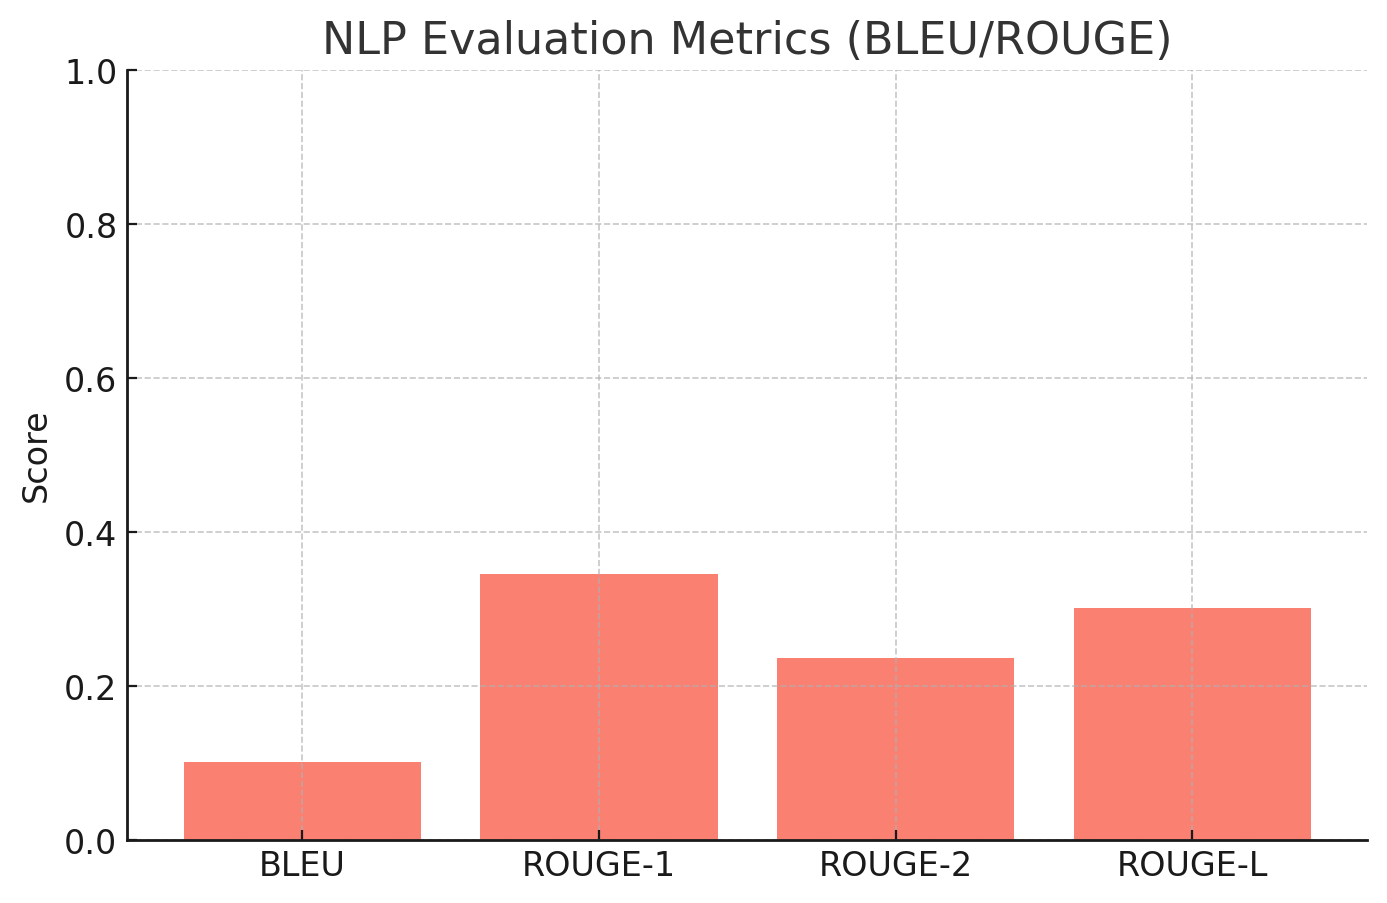

  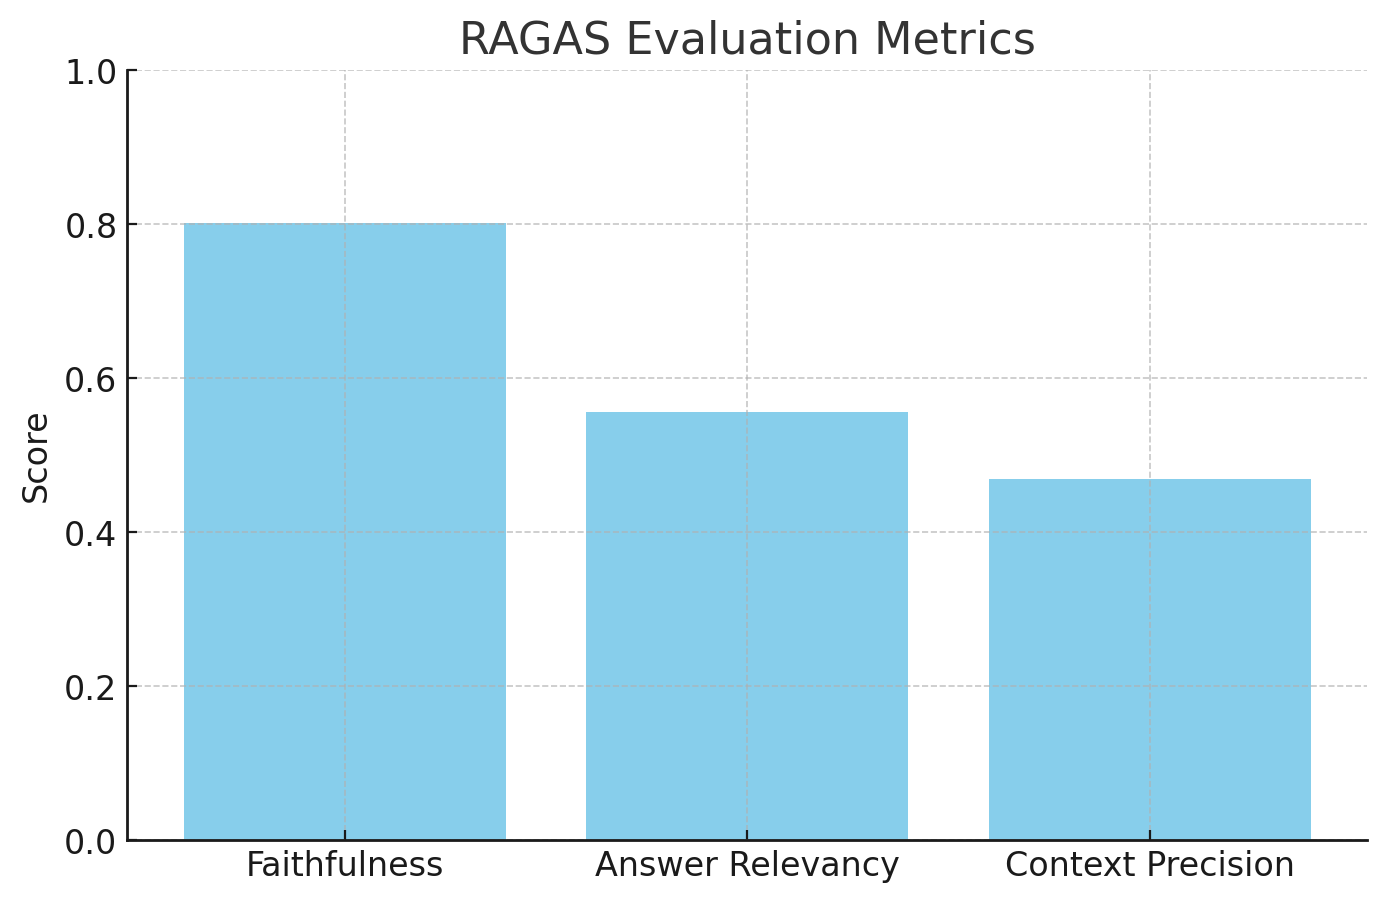

### Key Takeaways
  - The system is already faithful and fact-based, which is the most critical aspect for legal applications
  - The results show clear progress compared to the baseline, proving the effectiveness of the RAG setup
  - The evaluation framework (RAGAS + BLEU/ROUGE) provides a solid foundation for future benchmarking

### Further Improvements:
To further strengthen the system, the following directions can be explored:

  - Retrieval optimization – Using stronger rerankers to improve context precision
  - Answer generation tuning – Prompt refinement for concise and complete legal answers
  - Chunking strategies – Better document segmentation to reduce irrelevant retrieval

# **Conclusion:**

Overall, the project successfully demonstrates the design, implementation, and evaluation of a Legal RAG-based QA system. While current results are promising, particularly in faithfulness, further tuning of retrieval and answer generation is expected to significantly boost performance, making the system highly reliable for real-world legal information retrieval.

  





